In [1]:
import random
import math

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import CircuitInstruction, Instruction, Qubit, Clbit
from qiskit.tools.visualization import circuit_drawer

In [2]:
# Gate equivalence classes

mutableGateSet=('x','h','z','y','tdg','t','sx','sdg','s','id','i','u1','r','rz','ry','rx','p','u2','u3','u',
                'swap','iswap', 'dcx', 'cz', 'cy','cx', 'csx','ch','rzz','rzx','ryy','rxx','cu1','crz','cry',
                'crx','cp','gms','cswap','ccx')

gateEquivalenceDict = {"1q0p" : ['x','h','z','y','tdg','t','sx','sdg','s','id','i'],
                       "1q1p" : ['u1','r','rz','ry','rx','p'],
                       "1q2p" : ['u2'],
                       "1q3p" : ['u3','u'],
                       "2q0p" : ['swap','iswap', 'dcx', 'cz', 'cy','cx', 'csx','ch'],
                       "2q1p" : ['rzz','rzx','ryy','rxx','cu1','crz','cry','crx','cp'],
                       "3q0p" : ['gms','cswap','ccx'] }

# ms was deprecated, use gms instead

In [3]:
class Placeholder(CircuitInstruction):
    def __init__(self,  num_qubits, qubits, name = "Input", num_clbit=0, clbits=[], param=[], label="  Input  "):
        self.name = name
        super().__init__(Instruction(name, num_qubits, num_clbit, param, label),
                         qubits=qubits,clbits=clbits)

In [4]:
def mutant_gen_change_gate_name (testQC:QuantumCircuit, index:int, equivalenceGroup_name:str) -> QuantumCircuit:
    """
    testQC : QuantumCircuit, QC under test
    index : int, index in testQC.data to be mutated
    equivalenceGroup_name : str, name of the equivalence group of testQC.data[index].operator
    
    This function returns a copy the QC under test, obtains randomly a gate name from the equivalence 
        group, ensures it is no the same one and substitues the new gate name in the returning copy. 
    
    assert 0 <= index < len(testQC.data)
    assert testQC.data[index].operator.name in gateEquivalenceDict[equivalenceGroup_name]
    assert len(gateEquivalenceDict[equivalenceGroup_name]) > 1
    """
    
    assert len(gateEquivalenceDict[equivalenceGroup_name]) > 1
    mutant = testQC.copy()
    
    new_name = random.choice(gateEquivalenceDict[equivalenceGroup_name])
    
    while new_name == mutant.data[index].operation.name:
        new_name = random.choice(gateEquivalenceDict[equivalenceGroup_name])
        
    mutant.data[index].operation.name = new_name
    
    return mutant

In [5]:
def mutant_gen_change_gate_properties (testQC:QuantumCircuit, index:int) -> QuantumCircuit:
    """
    testQC : QuantumCircuit, QC under test
    index : int, index in testQC.data to be mutated
    
    This function returns a copy the QC under test changing the qubits and parameters
        on the CircuitInstruction in correspondent index. It obtains randomly a different
        qubit tuple and different parameters according to the gate needs if necessary.
    
    assert: 0 <= index < len(testQC.data)
    assert: testQC.data[index].operator.name not in gateEquivalenceDict["1q0p"]
    """
    mutant = testQC.copy()
    
    gate_num_qubits = mutant.data[index].operation.num_qubits
    gate_num_params = len(mutant.data[index].operation.params)
    
    new_qubits = tuple(random.sample(mutant.qubits, gate_num_qubits))
    if mutant.num_qubits > 1:
        # Only force different combination of qubits if circuit has more than 1 qubit.
        while new_qubits == mutant.data[index].qubits:
            new_qubits = tuple(random.sample(mutant.qubits, gate_num_qubits))
    
    new_params = [random.uniform(-math.pi/2,math.pi/2) for _ in range(gate_num_params)]
    if gate_num_params!=0:
        # Only force different parameters if there is parameters.
        while new_qubits == mutant.data[index].qubits:
            new_qubits = tuple(random.sample(mutant.qubits, gate_num_qubits))
    
    mutant.data[index].qubits = new_qubits
    mutant.data[index].operation.params = new_params
    
    return mutant

In [6]:
def mutant_gen_insert_gate(testQC:QuantumCircuit) -> QuantumCircuit:
    """
    testQC : QuantumCircuit, QC under test
    
    This function returns a copy the QC under test adding a new CircuitInstruction in 
        a random index. The new CircuitInstruction is obtained randomly within the 
        possibilities of the number of qubits in testQC.
    """
    
    mutant = testQC.copy()
    
    #It may take len(mutant.data) as index, due to being an insertion
    index = random.randint(0,len(mutant.data)) 
    
    gate_num_qubits = random.randint(0,mutant.num_qubits-1)
        
    gate_qubits = tuple(random.sample(mutant.qubits, gate_num_qubits))
    
    if gate_num_qubits == 1:
        
        gate_num_parameters = random.randint(0,3)
        gate_parameters = [random.uniform(-math.pi/2,math.pi/2) for _ in range(gate_num_parameters)]
        
        gate_name = random.choice(gateEquivalenceDict["1q"+str(gate_num_parameters)+"p"])
        
    elif gate_num_qubits == 2:
            
        gate_num_parameters = random.randint(0,1)
        gate_parameters = [random.uniform(-math.pi/2,math.pi/2) for _ in range(gate_num_parameters)]
        
        gate_name = random.choice(gateEquivalenceDict["2q"+str(gate_num_parameters)+"p"])
        
    else:
        
        gate_parameters = []
        gate_name = random.choice(gateEquivalenceDict["3q0p"])
    
    inst = Instruction(name=gate_name, num_qubits=gate_num_qubits, num_clbits=0, params=gate_parameters)
    cInt = CircuitInstruction(inst,gate_qubits)
    
    mutant.data.insert(index,cInt)
    
    return mutant

In [7]:
def mutant_generator_aux(testQC:QuantumCircuit, mutableIndex:int) -> QuantumCircuit:
    """
    testQC : QuantumCircuit, QC under test
    mutableIndex : int, index in testQC.data to be mutated
    
    This function returns a mutated QC. It randomly selects between the correct type 
        of mutation for the required circuit. The mutation operators are:
        
            - 0) Gate name change
            - 1) Gate qubits/parameters change
            - 2) Gate insertion
            - 3) Gate deletion
            
    assert: len(testQC.data) > 0
    assert: len(mutableGateSetIndex) > 0
    """
    
    mut_type=random.randint(0,3)
    # Select randomly the mutation operator
    
    if mut_type == 0:
        # Gate change within its equivalence class keeping same qubits and parameters
        
        # Exception: There is only one equivalent gate
        
        gate_name = testQC.data[mutableIndex].operation.name
        equivalenceGroup_name = str(testQC.data[mutableIndex].operation.num_qubits) + 'q' + str(len(testQC.data[mutableIndex].operation.params))+ 'p'
    
        exception = (len(gateEquivalenceDict[equivalenceGroup_name]) == 1)
        if exception:
            mutant = mutant_generator_aux(testQC, mutableIndex) 
        
        mutant = mutant_gen_change_gate_name(testQC, mutableIndex, equivalenceGroup_name)
        
    elif mut_type == 1 :
        # Gate changes in control/target qubit or parameters
        
        # Exception: Trying to mutate a 1 qubit operator with no parameters in 1 qubit QC
        exception = (testQC.num_qubits == 1 and (testQC.data[mutableIndex].operation.name in gateEquivalenceDict["1q0p"]))
        if exception:
            mutant = mutant_generator_aux(testQC, mutableIndex) 
        else:
            mutant = mutant_gen_change_gate_properties(testQC, mutableIndex)
        
    elif mut_type == 2:
        # Gate insertion 
        mutant = mutant_gen_insert_gate(testQC)
        
    else:
        # Gate deletion
        mutant = testQC.copy()
        del mutant.data[mutableIndex]
        
    return mutant

In [8]:
def mutant_generator(testQC:QuantumCircuit, num_mutants:int) -> [QuantumCircuit]:
    """
    testQC : QuantumCircuit, QC under test
    num_mutants : int, number of randomly generated mutants desired
    
    This function returns a list of num_mutants mutated QuantumCircuits. It makes a 
        difference with two extreme cases: No QuantumInstructions in the circuit and 
        No mutable gates in the circuit. In this cases, only gate insertion operator 
        is available.
            
    """
    assert num_mutants > 0
    
    if len(testQC.data) == 0:
        # Avoid extreme case of an empty QC.
        mutants = [mutant_gen_insert_gate(testQC) for _ in range(num_mutants)]
        
    else:
        mutableGateSetIndex=[i for i in range(len(testQC.data)) if testQC.data[i].operation.name in mutableGateSet]

        if len(mutableGateSetIndex) == 0:
            # Avoid the possibility of having only non mutable gates (out of our scope of mutability)
            mutants = [mutant_gen_insert_gate(testQC) for _ in range(num_mutants)]

        else:
            mutants = [mutant_generator_aux(testQC, mutableGateSetIndex[random.randint(0,len(mutableGateSetIndex)-1)]) 
                       for _ in range(num_mutants)]
    
    return mutants

In [9]:
def bv_fgenerator(qc,n0,s):
    s = s[::-1]
    n = len (s)
    for q in range(n):
        if s[q] == '0':
            qc.i(q+n0)
        else:
            qc.cx(q+n0, n+n0)

def bv_alg_mt(n):
    
    qs=QuantumRegister(n, 's')
    anc1=QuantumRegister(1, 'anc1')
    qc = QuantumCircuit(qs, anc1)

    for i in range(n+1):
        qc.h(i)
    qc.z(n)

    qc.barrier()
    qc.append(Placeholder(qc.num_qubits, qc.qubits))
    qc.barrier()
    
    for i in range(n):
        qc.h(i)
    
    return qc

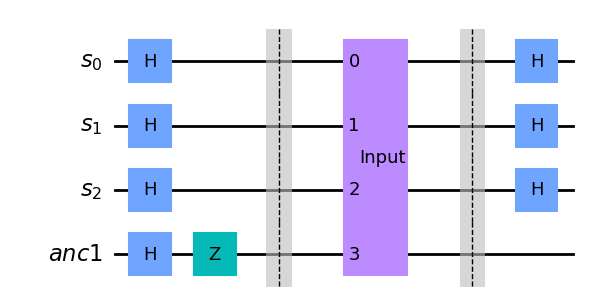

In [10]:
test=bv_alg_mt(3)

test.draw(output="mpl")

In [11]:
mutants=mutant_generator(test,5)

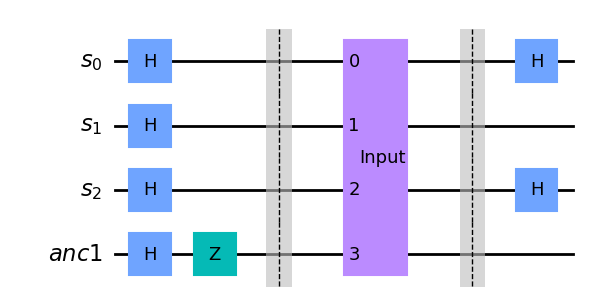

In [12]:
mutants[0].draw(output='mpl')

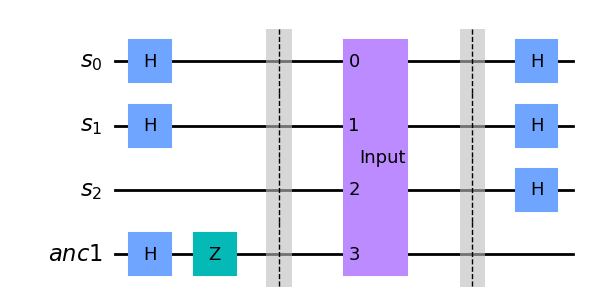

In [13]:
mutants[1].draw(output='mpl')

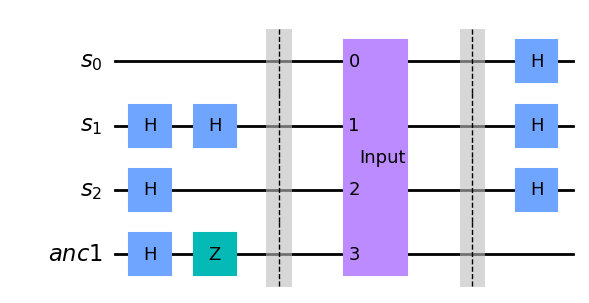

In [14]:
mutants[2].draw(output='mpl')

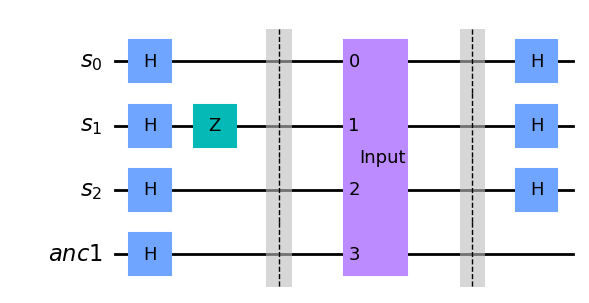

In [15]:
mutants[3].draw(output='mpl')

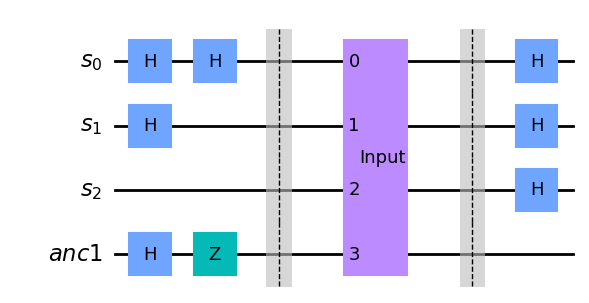

In [16]:
mutants[4].draw(output='mpl')